<a href="https://colab.research.google.com/github/tensorflow-project/FineTuning/blob/main/four_emotions/training_four_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow-project/FineTuning

Cloning into 'FineTuning'...
remote: Enumerating objects: 1587, done.
remote: Counting objects: 100% (550/550), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 1587 (delta 404), reused 352 (delta 247), pack-reused 1037
Receiving objects: 100% (1587/1587), 93.83 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (1123/1123), done.


In [2]:
import sys
import os
from google.colab import drive
import numpy as np
import keras
import tensorflow as tf

py_file_location = "/content/FineTuning/four_emotions"
sys.path.append(os.path.abspath(py_file_location))
py_file_location = "/content/FineTuning/models"
sys.path.append(os.path.abspath(py_file_location))

import try_textual_inversion as txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
### create an instance of the StableDiffusion() class
stable_diffusion = txt.StableDiffusion()

### our new concept which is later inserted in the different prompts (for training and image generation).
###The goal is to create an embedding for our placeholder_token
placeholder_token = "<my-broccoli-token>"


### Add our placeholder_token to our stable_diffusion Model
stable_diffusion.tokenizer.add_tokens(placeholder_token)

train_ds = txt.create_dataset(stable_diffusion, placeholder_token)

### beta is the diffusion rate 
noise_scheduler = txt.NoiseScheduler(
    ### beta_start determines the amount of noise added at the start of the denoising process
    beta_start=0.00085,
    ### beta_end at the end of the denoising process
    beta_end=0.012,
    ### the beta_schedule determines that the diffusion rate increases linearly
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

training_image_encoder = keras.Model(
        stable_diffusion.image_encoder.input,
        stable_diffusion.image_encoder.layers[-2].output,
    )
    
    
#EPOCHS = 50
### learning rate decays depending on the number of epochs to avoid convergence issues in few epochs 
### in the originial tutorial a scheduler is used but we experienced to have better results without a scheduler
"""learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)"""
### inizialize the optimizer
optimizer = tf.keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=1e-4, epsilon=1e-8, global_clipnorm=10
)

txt.textual_preprocessing(stable_diffusion, placeholder_token)

### embeddings for cosine similarity
sticker_embedding = []
cosine_similarity = []
cosine_similarity.append(txt.cosine_sim(txt.get_embedding("broccoli", stable_diffusion), txt.get_embedding(placeholder_token, stable_diffusion)))

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
202761/202761 [==============================] - 0s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


198180272/198180272 [==============================] - 1s 0us/step


In [ ]:
### EXECUTE THE FOLLOWING TWO BLOCKS ONLY IF YOU WANT TO CONTINUE TRAINING WITH SAVED WEIGTHS
### choose where to load the weights from, either from your google drive or you load our pretrained weights
### make sure to insert the exact name of your weight.npy
drive.mount("/content/drive")
path = '/content/drive/MyDrive/weight_four_emotions.npy'

In [ ]:
###load the array of the weights of the text encoder from the training
text_encoder_weights = np.load(path, allow_pickle=True)

### Set the weights of the text encoder
txt.stable_diffusion.text_encoder.set_weights(text_encoder_weights)

Epoch 1/1: 100%|██████████| 535/535 [15:17<00:00,  1.71s/it]


31/31 [==============================] - 103s 3s/step


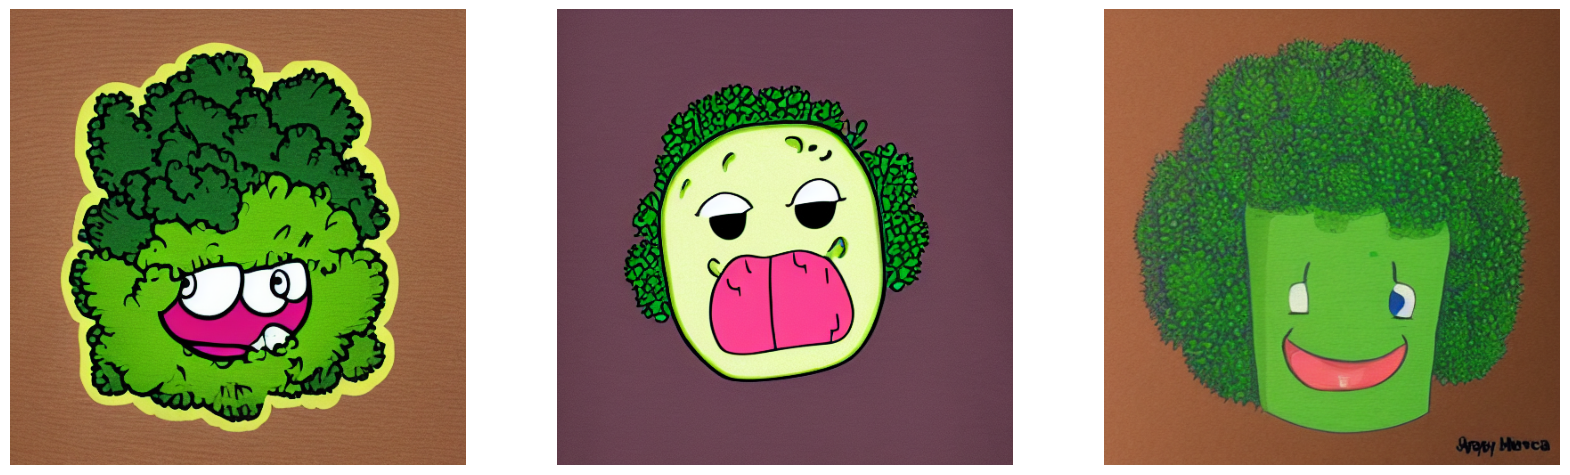

In [4]:
### how long to train for
epochs = 1
epoch_num = list(range(epochs+1))
txt.training(epochs, stable_diffusion, train_ds, sticker_embedding, cosine_similarity, stable_diffusion, noise_scheduler, training_image_encoder, optimizer, placeholder_token)

In [ ]:
### where to store your newly generated weights
drive.mount("/content/drive")
path = '/content/drive/MyDrive/weights_four_emotions.npy'

In [ ]:
### get the weights of the text encoder and save the to Google Drive
text_encoder_weights = np.array(txt.stable_diffusion.text_encoder.get_weights(), dtype=object)

### save the weights array to a file on your Google Drive
np.save(path, text_encoder_weights)

In [ ]:
### plot cosine similarity between old and new embedding
txt.cosine_plot(epoch_num, cosine_similarity)